# Build ML models with Pycaret

References:
- http://www.pycaret.org/tutorials/html/REG101.html
- https://github.com/pycaret/pycaret/blob/master/Tutorials/Regression%20Tutorial%20Level%20Intermediate%20-%20REG102.ipynb
- https://github.com/pycaret/pycaret/blob/master/Tutorials/Regression%20Tutorial%20Level%20Expert%20-%20REG103.ipynb

In [1]:
import pandas as pd
import settings
import os
from pycaret.regression import *

# Load datasets and create train/test

In [2]:
dataset = pd.read_csv(os.path.join('../data/processed', 'train-cleaned.csv'))
dataset.drop(columns=["Unnamed: 0"], inplace=True)
dataset.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,250000


In [31]:
# Create train and test datasets
data = dataset.sample(frac = 0.75, random_state = 42).reset_index(drop=True)
data_unseen = dataset.drop(data.index).reset_index(drop=True)

print("Data for modeling: " + str(data.shape))
print("Unseen Data for predictions: " + str(data_unseen.shape))

Data for modeling: (1095, 73)
Unseen Data for predictions: (365, 73)


# Modeling Setup


First we need to get numerical and categorical features.
Pycaret tries to automatically detect each type, so the following procedure is to fix the ones it classified wrong.

In [4]:
num_features = ['LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 
                'FullBath', 'HalfBath', 'BedroomAbvGr', 
                'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 
                'GarageCars', '3SsnPorch', 'PoolArea', 'MiscVal', 
                'MoSold', 'YrSold']

The setup function initializes the enviroments in pycaret and creates the transformation pipeline to prepare the data for modeling and deployment.

In [5]:
reg = setup(data=data, 
            target='SalePrice', 
            numeric_features=num_features, 
            #normalize= True, 
            #normalize_method = 'zscore',
            #remove_outliers=True,
            silent=True,
            session_id=1)

 
Setup Succesfully Completed!


,Description,Value
0,session_id,1
1,Transform Target,False
2,Transform Target Method,None
3,Original Data,"(1460, 73)"
4,Missing Values,True
5,Numeric Features,30
6,Categorical Features,42
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


# Testing all Models

In [6]:
compare_models(blacklist = ['tr', 'lar'], sort='RMSLE') #blacklisted Thielsen Regressor due to longer training times

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,15438.507800,790522127.541100,27029.364500,0.874800,0.121200,0.085400
1,Extreme Gradient Boosting,17575.683400,944849412.911700,29434.057000,0.851200,0.135200,0.098300
2,Gradient Boosting Regressor,17683.026200,959873718.979200,29721.325000,0.848800,0.137200,0.099500
3,Light Gradient Boosting Machine,17629.337700,958017443.597500,30025.593200,0.845300,0.139800,0.099200
4,Random Forest,18427.663000,1036583896.629500,30985.215200,0.836400,0.148500,0.106100
5,Lasso Least Angle Regression,17192.463800,1346413353.229400,32073.256400,0.755200,0.149700,0.095500
6,Extra Trees Regressor,19773.367100,1173010758.312600,33143.308900,0.813400,0.156500,0.111600
7,Ridge Regression,19205.116500,1359651003.066500,34164.486100,0.757500,0.160500,0.108700
8,Lasso Regression,19126.325500,1512855048.536700,34324.544500,0.722800,0.166300,0.109500
9,Orthogonal Matching Pursuit,18746.019900,1443012705.565500,33698.076100,0.736600,0.169500,0.107200


# Tunning 3 best models

From the table above, we can see that CatBoost Regressor, Extreme Gradient Boosting and Gradient Boosting Regressor got the best results.
Let's tunning then to get better results. In order to tune hyperparameters, the tune_model() function is used. This function automatically tunes the hyperparameters of a model on a pre-defined search space and scores it using kfold cross validation. 

In [14]:
catb = tune_model('catboost', optimize='mse') # Only ['mae', 'mse', 'r2'] can be optimized for CatBoost

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,15886.8241,1.031705e+09,32120.1576,0.7772,0.1475,0.0986
1,17559.9395,6.742041e+08,25965.4396,0.8810,0.1348,0.1005
2,17144.1280,6.840117e+08,26153.6180,0.8574,0.1261,0.0956
3,16386.7832,5.770375e+08,24021.6050,0.9057,0.1205,0.0910
4,19449.0191,1.747594e+09,41804.2364,0.7958,0.1630,0.1081
5,20933.1000,1.717692e+09,41445.0508,0.7857,0.1359,0.0996
6,17018.2026,6.546718e+08,25586.5547,0.8732,0.1181,0.0923
7,15527.8578,5.110241e+08,22605.8425,0.9016,0.1249,0.0879
8,12683.2372,2.885151e+08,16985.7313,0.9373,0.0991,0.0770
9,15667.8492,6.371503e+08,25241.8359,0.9030,0.1257,0.0930


In [16]:
xgb = tune_model('xgboost', optimize='mse')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,14193.5777,5.128456e+08,22646.0954,0.8892,0.1188,0.0864
1,14938.1167,5.915687e+08,24322.1862,0.8956,0.1185,0.0824
2,15643.0355,6.559621e+08,25611.7569,0.8633,0.1228,0.0874
3,18897.2302,9.533634e+08,30876.5839,0.8441,0.1311,0.0973
4,18956.3068,2.371443e+09,48697.4671,0.7229,0.1645,0.1018
5,20055.0836,1.573699e+09,39669.8766,0.8037,0.1322,0.0947
6,14456.6569,5.345574e+08,23120.4979,0.8965,0.1053,0.0775
7,14735.5371,4.622936e+08,21501.0131,0.9110,0.1194,0.0841
8,12122.1446,3.113074e+08,17643.9060,0.9324,0.1007,0.0729
9,15884.8827,6.541492e+08,25576.3410,0.9004,0.1351,0.0966


In [17]:
gbr = tune_model('gbr', optimize='mse')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,16212.7200,9.040244e+08,30066.9980,0.8048,0.1450,0.1007
1,19626.6514,8.380026e+08,28948.2741,0.8521,0.1436,0.1088
2,15295.2964,5.688888e+08,23851.3909,0.8814,0.1319,0.0918
3,20764.3538,1.261963e+09,35524.1219,0.7937,0.1528,0.1099
4,25217.8751,2.281362e+09,47763.6004,0.7334,0.1891,0.1282
5,21329.1081,2.445657e+09,49453.5849,0.6949,0.1538,0.0971
6,17247.4018,8.599554e+08,29324.9956,0.8335,0.1223,0.0913
7,20271.9221,1.046356e+09,32347.4261,0.7985,0.1496,0.1069
8,16526.5035,5.760031e+08,24000.0654,0.8749,0.1159,0.0901
9,20082.8975,1.157286e+09,34018.9047,0.8238,0.1671,0.1206


After tunning, XGboost show the better results.

# Error Analysis

### Residuals plot

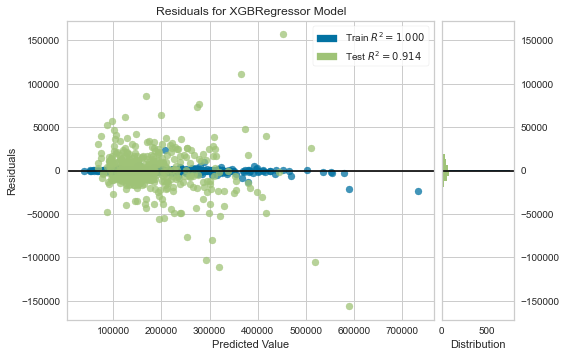

In [18]:
plot_model(xgb)

We can see, that error are concentraded in the range from -50000 to 50000. 

There are some error above +-100000, but these are just 6 points.

### Prediction errors plot

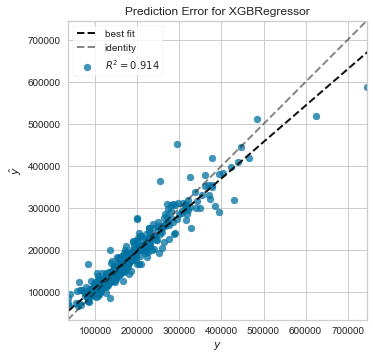

In [20]:
plot_model(xgb, plot='error')

The model seems to be predict values lower than the real value.

### Feature Importance plot

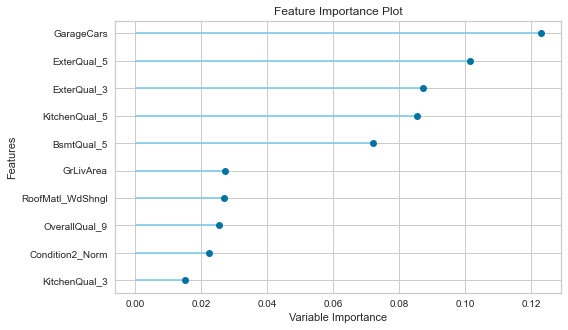

In [21]:
plot_model(xgb, plot='feature')

The number of car in the garage and external quality of the houses seems to be the most important features to perform the predictions.

In [25]:
evaluate_model(xgb)

,Parameters
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,0.9
gamma,0
importance_type,gain
learning_rate,0.02
max_delta_step,0
max_depth,40


# Predict on test / hold-out Sample

During setup, 30% of the data has been separated out as a test/hold-out sample. 

All of the evaluation metrics we have seen above are cross validated results based on training set (70%) only. 

Now, using our trained model we will predict the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [26]:
predict_model(xgb)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting Regressor,15585.4912,6.112219e+08,24722.9021,0.9145,0.1475,0.1005


,LotArea,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SalePrice,Label
0,12435.0,2001.0,2001.0,361.0,0.0,602.0,963.0,963.0,829.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,231500,211842.593750
1,8400.0,1939.0,1997.0,378.0,0.0,342.0,720.0,1052.0,720.0,420.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,179500,180040.859375
2,9819.0,1967.0,1967.0,450.0,0.0,432.0,882.0,900.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,122000,115519.656250
3,1936.0,1970.0,1970.0,131.0,499.0,0.0,630.0,630.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,84500,76354.492188
4,12160.0,1959.0,1959.0,1000.0,0.0,188.0,1188.0,1188.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,142000,149802.484375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,4590.0,2006.0,2006.0,24.0,0.0,1530.0,1554.0,1554.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,209500,234137.906250
435,4017.0,2006.0,2007.0,0.0,0.0,625.0,625.0,625.0,625.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,171900,163887.500000
436,10852.0,2000.0,2000.0,786.0,0.0,173.0,959.0,959.0,712.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,173000,193040.843750
437,32668.0,1957.0,1975.0,1219.0,0.0,816.0,2035.0,2515.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,200624,274148.062500


# Finalize Model for Deployment

The finalize_model() function fits the model onto the complete dataset including the test/hold-out sample (30% in this case). The purpose of this function is to train the model on the complete dataset before it is deployed in production.

In [27]:
final_xgb = finalize_model(xgb)
print(final_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0,
             importance_type='gain', learning_rate=0.02, max_delta_step=0,
             max_depth=40, min_child_weight=1, missing=None, n_estimators=600,
             n_jobs=-1, nthread=None, objective='reg:linear', random_state=1,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.5, verbosity=0)


# Predict on unseen data

In [36]:
unseen_predictions = predict_model(xgb, data=data_unseen)
unseen_predictions.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Label
0,20,RL,9317,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,3,2007,WD,Normal,176432,176774.000000
1,70,RM,6882,Pave,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,...,0,0,0,0,3,2007,WD,Normal,127000,126746.140625
2,120,RL,3696,Pave,Reg,Lvl,AllPub,Inside,Gtl,StoneBr,...,0,0,0,0,10,2007,WD,Normal,170000,169590.312500
3,50,RM,6000,Pave,Reg,Lvl,AllPub,Inside,Gtl,BrkSide,...,0,0,0,0,7,2009,WD,Normal,128000,127564.070312
4,20,RL,11880,Pave,IR1,Lvl,AllPub,Inside,Gtl,NWAmes,...,0,0,0,0,4,2009,COD,Abnorml,157000,157063.578125


In [ ]:
# compute metrics???

# Saving the model

In [37]:
save_model(final_xgb,'Final XGB Model 20June2020')

Transformation Pipeline and Model Succesfully Saved


xgboost.sklearn.XGBRegressor

#### TODO

- remove GarageCars or GarageSize
- Como lidar com as datas, numericos ou do tipo data?
- Checar missing values
- Set ordinal features


#### TO Read: 
https://www.dataquest.io/blog/understanding-regression-error-metrics/
https://www.kaggle.com/teampycaret/house-prices-prediction-using-pycaret    